# League of Legends Wiki Web Scraping and Data Analysis

## Goal

In this project we will use the BeautifulSoup library to webscrape three separate pages and combine their data into a single Pandas dataframe. We will then perform exploratory data analysis on this dataframe.

First, the League of Legends wiki page to get a table of a list of champions (in game characters), their respective release dates, and the in game prices for them (in two currencies known as 'Blue Essence' and 'RP').

Second, the League of Legends Skins wiki page to get a table of the same list of champions and their skins (in-game cosmetic variations).

Finally, a League of Legends 'picks' page to get a table of the list of champions and their 'pick-rates' or how often said champion is picked in a game. This can also be referred to as the champions' popularity in %.

In [1]:
import requests
import html5lib
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup

## First Table

In [2]:
champs_list_url = 'https://leagueoflegends.fandom.com/wiki/List_of_champions'
data = requests.get(champs_list_url)

parser = BeautifulSoup(data.text, 'html.parser')
champs = pd.read_html(data.text)[0]
champs

,Champion,Classes,Release Date,Last Changed,Blue Essence,RP
0,Aatrox the Darkin Blade,Juggernaut,2013-06-13,V13.17,4800,880
1,Ahri the Nine-Tailed Fox,Burst,2011-12-14,V13.19,3150,790
2,Akali the Rogue Assassin,Assassin,2010-05-11,V13.16,3150,790
3,Akshan the Rogue Sentinel,Marksman Assassin,2021-07-22,V13.17,4800,880
4,Alistar the Minotaur,Vanguard,2009-02-21,V13.7,1350,585
...,...,...,...,...,...,...
160,Zeri The Spark of Zaun,Marksman,2022-01-20,V13.19,6300,975
161,Ziggs the Hexplosives Expert,Artillery,2012-02-01,V13.19,4800,880
162,Zilean the Chronokeeper,Specialist,2009-04-18,V13.3,1350,585
163,Zoe the Aspect of Twilight,Burst,2017-11-21,V13.17,4800,880


In order to simplify the champion names, we remove their titles. For example, 'Teemo the Swift Scout' becomes just 'Teemo'

In [3]:
champs['Champion'] = champs['Champion'].str.split().str[0]

## Second Table

A look at the HTML elements we're dealing with on this page

In [4]:
skins_list_url = 'https://leagueoflegends.fandom.com/wiki/List_of_skins_by_champion'
data = requests.get(skins_list_url)

parser = BeautifulSoup(data.text, 'html.parser')
html_skins_list = parser.select('li.skin-icon')
html_skins_list[0]

<li class="skin-icon" data-champion="Aatrox" data-game="lol" data-skin="Justicar"><img alt="Aatrox JusticarCircle" data-image-key="Aatrox_JusticarCircle.png" data-image-name="Aatrox JusticarCircle.png" data-relevant="0" decoding="async" height="26" loading="lazy" src="https://static.wikia.nocookie.net/leagueoflegends/images/b/b7/Aatrox_JusticarCircle.png/revision/latest/scale-to-width-down/26?cb=20201218013349" width="26"/></li>

In [5]:
dic_champ_skins = {}
for i in html_skins_list:
    champ = i['data-champion']
    skin = i['data-skin']
    if champ not in dic_champ_skins:
        dic_champ_skins[champ] = [skin]
    else:
        dic_champ_skins[champ].append(skin)
        
        
#dic_champ_skins

In [6]:
skin_series = pd.Series(dic_champ_skins)
skindf = skin_series.to_frame()
skindf = skindf.reset_index()
skindf = skindf.rename(columns={0:'Skins', 'index':'Champion'})

In [7]:
skindf['Num Skins'] = ''
for i in range(0, skindf.shape[0]):
    skindf['Num Skins'][i] = len(skindf['Skins'][i]) 
skindf

,Champion,Skins,Num Skins
0,Aatrox,"[Justicar, Mecha, Sea Hunter, Blood Moon, Odys...",11
1,Ahri,"[Midnight, Dynasty, Foxfire, Popstar, Academy,...",17
2,Akali,"[Nurse, Blood Moon, Silverfang, Headhunter, Sa...",19
3,Akshan,"[Cyber Pop, Crystal Rose]",2
4,Alistar,"[Golden, Infernal, Marauder, Moo Cow, Blackfro...",14
...,...,...,...
160,Zeri,"[Withered Rose, Ocean Song, Immortal Journey]",3
161,Ziggs,"[Mad Scientist, Pool Party, Master Arcanist, B...",11
162,Zilean,"[Groovy, Shurima Desert, Blood Moon, Sugar Rus...",7
163,Zoe,"[Cyber Pop, Pool Party, Star Guardian, Arcanis...",7


## Third Table

The data on the page we want is being created by JavaScript. Python's Requests library can't handle elements generated by JavaScript so we use a combination of Selenium and ChromeWebDrive to get the page source. From there we can use BeautifulSoup again to parse the HTML.

### Note:
In order for the program to run successfully, the chromedriver.exe file must be placed in the same filepath as the .ipynb file. Refer to https://chromedriver.chromium.org/downloads

### Note 2:
This part of the program does take longer to run as it simulates a standalone server that Selenium WebDriver uses to launch Google Chrome. Please be patient :)

In [8]:
pick_rate_url = 'https://www.leagueofgraphs.com/champions/builds'

from selenium import webdriver
from selenium.webdriver.chrome.options import Options

options = Options()
options.add_argument('--headless')
options.add_argument('--disable-gpu')

driver = webdriver.Chrome(options=options)
driver.get(pick_rate_url)
page = driver.page_source
driver.quit()
parser = BeautifulSoup(page, 'html.parser')

In [9]:
pick_table = parser.find_all('table')[0]
#pick_table

In [10]:
c_names = pick_table.find_all('span', class_='name')
pick_champ_names_list = [name.text.strip() for name in c_names]
#pick_champ_names_list

In [11]:
pick_rates_list = [div.find_next(string=True) for div in pick_table.find_all('div', class_='full-progress-bar wgblue')]
#pick_rates_list

In [12]:
pick_rates_df = pd.DataFrame(list(zip(pick_champ_names_list, pick_rates_list)), columns=['Champion','Pick Rates'])
pick_rates_df

,Champion,Pick Rates
0,Kai'Sa,28.9%
1,Ezreal,23.7%
2,Jhin,17.0%
3,Caitlyn,16.8%
4,Lee Sin,16.6%
...,...,...
160,Kog'Maw,1.8%
161,Ivern,1.7%
162,Rek'Sai,1.4%
163,Skarner,1.0%


## Merging

Now we can use Pandas to merge our three tables into one dataframe on the Champion column.

In [13]:
pd.set_option('display.max_rows', None)
merged_df = champs.merge(skindf, left_index=True, right_index=True, suffixes=(None, '_right'))
#merged_df

In [14]:
merged_df['Champion'] = merged_df['Champion_right']
merged_df = merged_df.drop(columns=['Champion_right'])

Preview of our final dataframe

In [15]:
finaldf = merged_df.merge(pick_rates_df, on='Champion')
finaldf

,Champion,Classes,Release Date,Last Changed,Blue Essence,RP,Skins,Num Skins,Pick Rates
0,Aatrox,Juggernaut,2013-06-13,V13.17,4800,880,"[Justicar, Mecha, Sea Hunter, Blood Moon, Odys...",11,11.2%
1,Ahri,Burst,2011-12-14,V13.19,3150,790,"[Midnight, Dynasty, Foxfire, Popstar, Academy,...",17,8.4%
2,Akali,Assassin,2010-05-11,V13.16,3150,790,"[Nurse, Blood Moon, Silverfang, Headhunter, Sa...",19,9.5%
3,Akshan,Marksman Assassin,2021-07-22,V13.17,4800,880,"[Cyber Pop, Crystal Rose]",2,3.8%
4,Alistar,Vanguard,2009-02-21,V13.7,1350,585,"[Golden, Infernal, Marauder, Moo Cow, Blackfro...",14,6.7%
5,Amumu,Vanguard,2009-06-26,V13.11,450,260,"[Emumu, Little Knight, Sad Robot, Surprise Par...",13,3.6%
6,Anivia,Battlemage,2009-07-10,V13.13,3150,790,"[Bird of Prey, Blackfrost, Prehistoric, Festiv...",12,2.6%
7,Annie,Burst,2009-02-21,V13.15,450,260,"[Frostfire, Reverse, Panda, Super Galaxy, Cafe...",15,1.9%
8,Aphelios,Marksman,2019-12-11,V13.14,4800,880,"[Nightbringer, Spirit Blossom, Lunar Beast, EDG]",4,5.2%
9,Ashe,Marksman,2009-02-21,V13.12,450,260,"[Sherwood Forest, Woad, Amethyst, Marauder, PR...",16,13.3%


## Data Cleaning

One of our final steps involves data cleaning. We will convert the Release Date column into a Datetime object, Blue Essence and RP columns as int types, Number of Skins column as int type, and remove the '%' from our Pick Rates column and convert to float. This enables us to perform exploratory data analysis later.

In [16]:
finaldf['Release Date'] = pd.to_datetime(finaldf['Release Date'])

finaldf['Blue Essence'] = finaldf['Blue Essence'].astype(int)

finaldf['RP'] = finaldf['RP'].astype(int)

finaldf['Num Skins'] = finaldf['Num Skins'].astype(int)

In [17]:
finaldf['Pick Rates'] = finaldf['Pick Rates'].str.replace('%', '')
finaldf['Pick Rates'] = finaldf['Pick Rates'].astype(float)

In [18]:
finaldf['Days Since Release'] = pd.Timestamp.now() -  finaldf['Release Date']
finaldf['Days Since Release'] = finaldf['Days Since Release'].astype('timedelta64[D]')

finaldf

,Champion,Classes,Release Date,Last Changed,Blue Essence,RP,Skins,Num Skins,Pick Rates,Days Since Release
0,Aatrox,Juggernaut,2013-06-13,V13.17,4800,880,"[Justicar, Mecha, Sea Hunter, Blood Moon, Odys...",11,11.2,3770.0
1,Ahri,Burst,2011-12-14,V13.19,3150,790,"[Midnight, Dynasty, Foxfire, Popstar, Academy,...",17,8.4,4317.0
2,Akali,Assassin,2010-05-11,V13.16,3150,790,"[Nurse, Blood Moon, Silverfang, Headhunter, Sa...",19,9.5,4899.0
3,Akshan,Marksman Assassin,2021-07-22,V13.17,4800,880,"[Cyber Pop, Crystal Rose]",2,3.8,809.0
4,Alistar,Vanguard,2009-02-21,V13.7,1350,585,"[Golden, Infernal, Marauder, Moo Cow, Blackfro...",14,6.7,5343.0
5,Amumu,Vanguard,2009-06-26,V13.11,450,260,"[Emumu, Little Knight, Sad Robot, Surprise Par...",13,3.6,5218.0
6,Anivia,Battlemage,2009-07-10,V13.13,3150,790,"[Bird of Prey, Blackfrost, Prehistoric, Festiv...",12,2.6,5204.0
7,Annie,Burst,2009-02-21,V13.15,450,260,"[Frostfire, Reverse, Panda, Super Galaxy, Cafe...",15,1.9,5343.0
8,Aphelios,Marksman,2019-12-11,V13.14,4800,880,"[Nightbringer, Spirit Blossom, Lunar Beast, EDG]",4,5.2,1398.0
9,Ashe,Marksman,2009-02-21,V13.12,450,260,"[Sherwood Forest, Woad, Amethyst, Marauder, PR...",16,13.3,5343.0


In [19]:
finaldf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 165 entries, 0 to 164
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Champion            165 non-null    object        
 1   Classes             165 non-null    object        
 2   Release Date        165 non-null    datetime64[ns]
 3   Last Changed        165 non-null    object        
 4   Blue Essence        165 non-null    int32         
 5   RP                  165 non-null    int32         
 6   Skins               165 non-null    object        
 7   Num Skins           165 non-null    int32         
 8   Pick Rates          165 non-null    float64       
 9   Days Since Release  165 non-null    float64       
dtypes: datetime64[ns](1), float64(2), int32(3), object(4)
memory usage: 12.2+ KB


## Exploratory Data Analysis

Now that most of our columns are integer or float type, we can create a quick correlations table to identify any correlations between our columns.

In [20]:
finaldf.corr(numeric_only=True)

,Blue Essence,RP,Num Skins,Pick Rates,Days Since Release
Blue Essence,1.000000,0.842006,-0.566317,-0.245696,-0.538231
RP,0.842006,1.000000,-0.559253,-0.143309,-0.490867
Num Skins,-0.566317,-0.559253,1.000000,0.326789,0.727354
Pick Rates,-0.245696,-0.143309,0.326789,1.000000,-0.072213
Days Since Release,-0.538231,-0.490867,0.727354,-0.072213,1.000000


We'll also use the Seaborn library to create a color-coded correlation heatmap to make it easier to identify correlations.

Text(0.5, 1.0, 'Correlation Heatmap')

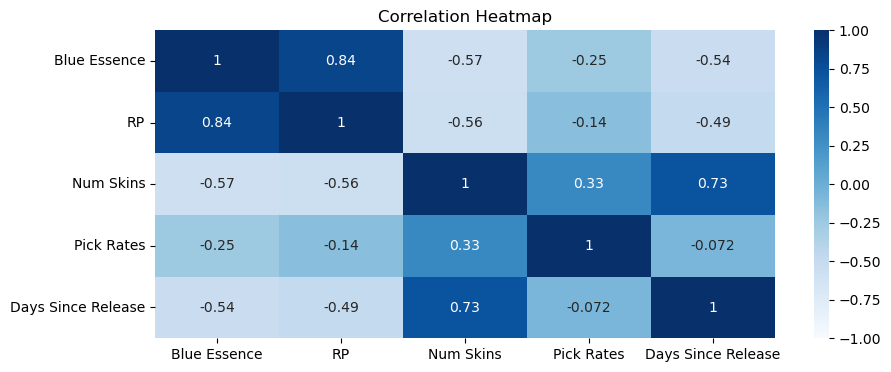

In [21]:
import seaborn as sns

plt.figure(figsize=(10,4))
heatmap = sns.heatmap(finaldf.corr(numeric_only=True), vmin=-1, vmax=1, cmap='Blues', annot=True)
heatmap.set_title('Correlation Heatmap')

### Findings:
We can see that our strongest correlations lie in the Blue Essence and RP columns with a correlation of 0.84. This is no surprise really as they are essentially the same currency but in different forms. Blue Essence is gained via free to play means and used for buying ONLY champions. RP can only be obtained by buying it (real tangible money)via the ingame store and is used for buying champions OR skins. Champions that cost more Blue Essence cost more RP and vice versa.

Our second strongest correlation is the Number of Skins and Days Since Release columns with 0.73. Champions that are older have more available skins while champions that are newer have much less skins available. Champions will always release with atleast one skin.

Earlier we determined that 'pick rates' can also be referred to popularity of a champion in that patch (bi weekly update). At 0.31, we see that there is not really a strong correlation between how many skins a champion has and how popular a champion is.

## EDA Continued

### Top 5 Most Popular Champions

In [32]:
finaldf.sort_values('Pick Rates', ascending=False).head(5)

,Champion,Classes,Release Date,Last Changed,Blue Essence,RP,Skins,Num Skins,Pick Rates,Days Since Release
53,Kai'Sa,Marksman,2018-03-07,V13.15,1350,585,"[Bullet Angel, KDA, Arcade, KDA ALL OUT, Lagoo...",11,28.9,2042.0
30,Ezreal,Marksman,2010-03-16,V13.8,1350,585,"[Frosted, Pulsefire, Debonair, Ace of Spades, ...",17,23.7,4955.0
50,Jhin,Marksman Catcher,2016-02-01,V13.19,4444,880,"[High Noon, Blood Moon, PROJECT, Dark Cosmic, ...",10,17.0,2807.0
18,Caitlyn,Marksman,2011-01-04,V13.17,450,260,"[Resistance, Officer, Arctic Warfare, Headhunt...",17,16.8,4661.0
67,Lee Sin,Diver,2011-04-01,V13.19,1350,585,"[Traditional, Acolyte, Dragon Fist, Muay Thai,...",15,16.6,4574.0


### Top 5 Least Popular Champions

In [40]:
finaldf.sort_values('Pick Rates').head(5)

,Champion,Classes,Release Date,Last Changed,Blue Essence,RP,Skins,Num Skins,Pick Rates,Days Since Release
22,Corki,Marksman,2009-09-19,V12.22,3150,790,"[Urfrider, Dragonwing, Arcade, Corgi, Astronau...",10,1.0,5133.0
120,Skarner,Diver,2011-08-09,V13.4,4800,880,"[Earthrune, Sandscourge, Battlecast Alpha, Gua...",5,1.0,4444.0
101,Rek'Sai,Diver,2014-12-11,V13.19,4800,880,"[Eternum, Pool Party, Blackfrost, Elderwood]",4,1.4,3224.0
45,Ivern,Catcher,2016-10-05,V13.19,4800,880,"[Candy King, Dunkmaster, Old God, Astronaut]",4,1.7,2560.0
65,Kog'Maw,Marksman,2010-06-24,V13.12,4800,880,"[Monarch, Lion Dance, Jurassic, Battlecast, Pu...",14,1.8,4855.0


### Top 10 Champions by Number of Skins

In [41]:
finaldf.sort_values('Num Skins', ascending=False).head(10)

,Champion,Classes,Release Date,Last Changed,Blue Essence,RP,Skins,Num Skins,Pick Rates,Days Since Release
2,Akali,Assassin,2010-05-11,V13.16,3150,790,"[Nurse, Blood Moon, Silverfang, Headhunter, Sa...",19,9.5,4899.0
79,Miss Fortune,Marksman,2010-09-08,V13.3,450,260,"[Waterloo, Cowgirl, Crime City, Arcade, Captai...",19,8.4,4779.0
73,Lux,Burst Artillery,2010-10-19,V13.17,450,260,"[Spellthief, Sorceress, Commando, Steel Legion...",19,16.4,4738.0
1,Ahri,Burst,2011-12-14,V13.19,3150,790,"[Midnight, Dynasty, Foxfire, Popstar, Academy,...",17,8.4,4317.0
30,Ezreal,Marksman,2010-03-16,V13.8,1350,585,"[Frosted, Pulsefire, Debonair, Ace of Spades, ...",17,23.7,4955.0
18,Caitlyn,Marksman,2011-01-04,V13.17,450,260,"[Resistance, Officer, Arctic Warfare, Headhunt...",17,16.8,4661.0
106,Riven,Skirmisher,2011-09-14,V13.4,4800,880,"[Crimson Elite, Redeemed, Battle Bunny, Arcade...",16,4.7,4408.0
119,Sivir,Marksman,2009-02-21,V13.12,450,260,"[Warrior Princess, Bandit, Warden, Pizza Deliv...",16,6.2,5343.0
58,Katarina,Assassin,2009-09-19,V13.15,3150,790,"[Mercenary, High Command, Sandstorm, Warring K...",16,6.2,5133.0
140,Vayne,Marksman,2011-05-10,V13.15,3150,790,"[Aristocrat, Dragonslayer, Arclight, PROJECT, ...",16,11.7,4535.0
